In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import gc

# Load the data
train_transaction = pd.read_csv('/content/drive/MyDrive/Projects_dl/Fraud detection/data/train_transaction.csv')
train_identity = pd.read_csv('/content/drive/MyDrive/Projects_dl/Fraud detection/data/train_identity.csv')
test_transaction = pd.read_csv('/content/drive/MyDrive/Projects_dl/Fraud detection/data/test_transaction.csv')
test_identity = pd.read_csv('/content/drive/MyDrive/Projects_dl/Fraud detection/data/test_identity.csv')

# Reduce memory usage
def reduce_memory_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
          col_type = df[col].dtype
          if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    # Rename columns to replace hyphens with underscores
    df.columns = df.columns.str.replace('-', '_')  # Add this line to rename columns

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df



In [ ]:
train_transaction = reduce_memory_usage(train_transaction)
train_identity = reduce_memory_usage(train_identity)
test_transaction = reduce_memory_usage(test_transaction)
test_identity = reduce_memory_usage(test_identity)



Memory usage after optimization is: 487.16 MB
Decreased by 72.6%
Memory usage after optimization is: 10.00 MB
Decreased by 77.8%
Memory usage after optimization is: 425.24 MB
Decreased by 72.0%
Memory usage after optimization is: 9.84 MB
Decreased by 77.8%


In [ ]:
# Merge the datasets on TransactionID
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

del train_transaction, train_identity, test_transaction, test_identity
gc.collect()



print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (590540, 434)
Test shape: (506691, 433)


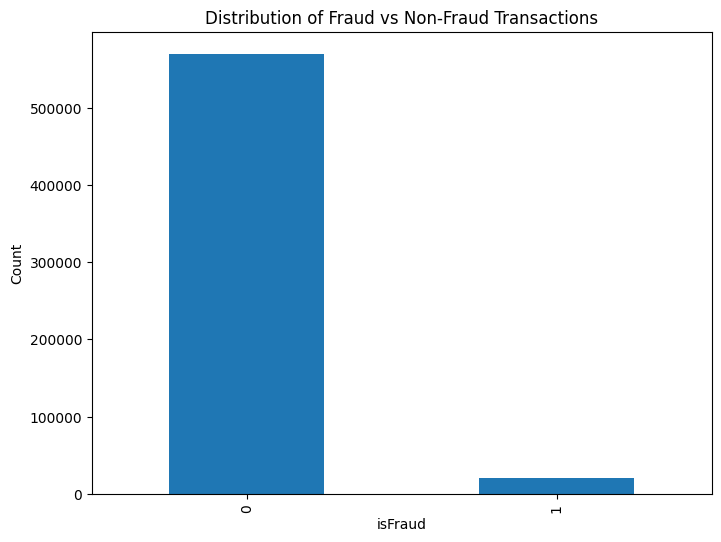

In [ ]:
import matplotlib.pyplot as plt

# Visualize distribution of target variable
plt.figure(figsize=(8, 6))
train['isFraud'].value_counts().plot(kind='bar')
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.show()

In [ ]:
import seaborn as sns

In [ ]:
# Handle missing values for categorical features by filling with 'unknown'
for col in train.select_dtypes(include='object').columns:
    train[col] = train[col].fillna('unknown')
    test[col] = test[col].fillna('unknown')

# Handle missing values for numerical features by filling with the median value
imputer = SimpleImputer(strategy='median')

# Fit and transform on the training data, excluding 'isFraud' and 'TransactionID'
train[train.select_dtypes(include='number').columns.difference(['isFraud', 'TransactionID'])] = \
    imputer.fit_transform(train.select_dtypes(include='number').drop(columns=['isFraud', 'TransactionID']))

# Transform the test data, excluding 'TransactionID'
test[test.select_dtypes(include='number').columns.difference(['TransactionID'])] = \
    imputer.transform(test.select_dtypes(include='number').drop(columns=['TransactionID']))




In [ ]:
# One-hot encode categorical features
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

In [ ]:
# Feature Engineering: Extracting date features from TransactionDT
train['TransactionDT'] = pd.to_datetime(train['TransactionDT'], unit='s', origin='unix')
test['TransactionDT'] = pd.to_datetime(test['TransactionDT'], unit='s', origin='unix')

train['Transaction_day'] = train['TransactionDT'].dt.day
train['Transaction_hour'] = train['TransactionDT'].dt.hour
test['Transaction_day'] = test['TransactionDT'].dt.day
test['Transaction_hour'] = test['TransactionDT'].dt.hour


# Dropping the original TransactionDT as we have extracted useful features from it
train.drop(columns=['TransactionDT'], inplace=True)
test.drop(columns=['TransactionDT'], inplace=True)

In [ ]:
# Feature Scaling: Standardize numerical features
scaler = StandardScaler()
numerical_cols = train.select_dtypes(include='number').columns.difference(['isFraud', 'TransactionID']) # Exclude 'isFraud' from scaling

train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])

In [ ]:
# Separate the target variable 'isFraud' from the feature set
X = train.drop(columns=['isFraud', 'TransactionID'])
y = train['isFraud']

In [ ]:
# Prepare the test set by dropping 'TransactionID'
X_test = test.drop(columns=['TransactionID'])


In [ ]:
# Split the training data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def align_features(X_train, X_test):
    # Get the column names from the training set
    train_columns = X_train.columns

    # Identify columns in test set that are not in train set
    new_columns = set(X_test.columns) - set(train_columns)

    # Add missing columns to test set with zero values
    for col in train_columns:
        if col not in X_test.columns:
            X_test[col] = 0

    # Remove extra columns from test set
    X_test = X_test[train_columns]

    return X_test

# Align the features
X_test_aligned = align_features(X_train, X_test)

<ipython-input-24-43bd0f9a344b>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[col] = 0
<ipython-input-24-43bd0f9a344b>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[col] = 0
<ipython-input-24-43bd0f9a344b>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[col] = 0
<ipytho

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot ROC Curve
def plot_roc_curve(y_true, y_pred_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_true, y_pred_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


In [ ]:
# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_val_pred_proba_lr = log_reg.predict_proba(X_val)[:, 1]
y_val_pred_lr = log_reg.predict(X_val)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print("Logistic Regression ROC AUC:", roc_auc_score(y_val, y_val_pred_proba_lr))

Logistic Regression ROC AUC: 0.8742852391082819


In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
print("Classification Report:")
print(classification_report(y_val, y_val_pred_lr))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    113866
           1       0.85      0.29      0.44      4242

    accuracy                           0.97    118108
   macro avg       0.91      0.65      0.71    118108
weighted avg       0.97      0.97      0.97    118108



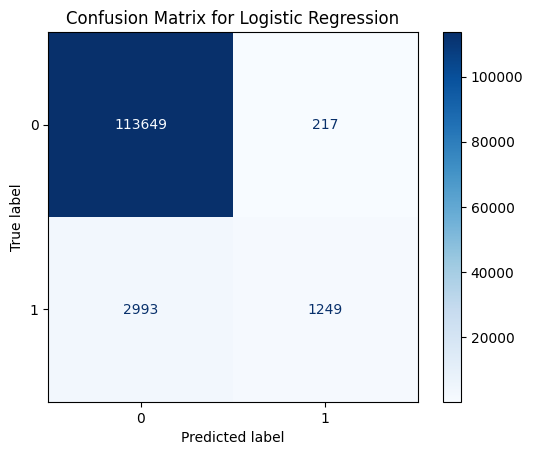

In [ ]:
# Plot Confusion Matrix for Logistic Regression
plot_confusion_matrix(y_val, y_val_pred_lr, 'Logistic Regression')

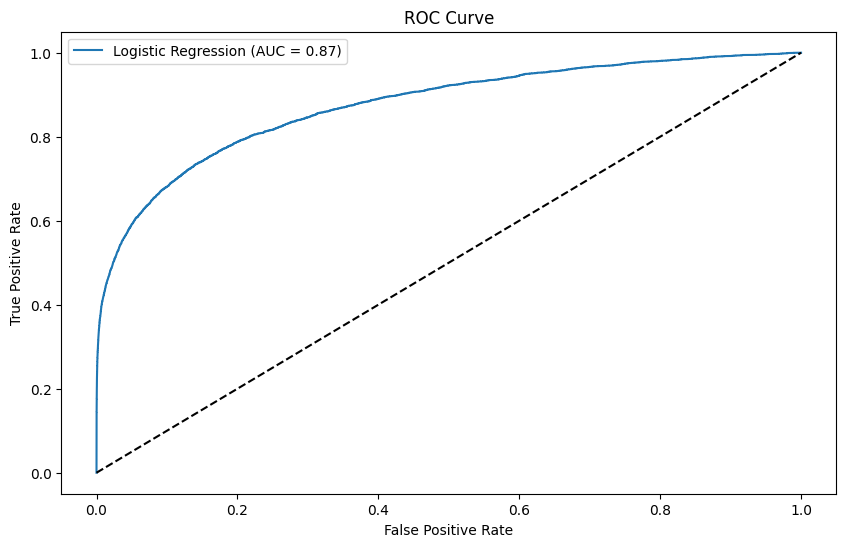

In [ ]:
# Plot ROC Curve for Logistic Regression
plot_roc_curve(y_val, y_val_pred_proba_lr, 'Logistic Regression')

In [ ]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_val_pred_proba_rf = rf.predict_proba(X_val)[:, 1]
y_val_pred_rf = rf.predict(X_val)

In [ ]:
print("Random Forest ROC AUC:", roc_auc_score(y_val, y_val_pred_proba_rf))

Random Forest ROC AUC: 0.9309374755522329


In [ ]:
print("Classification Report:")
print(classification_report(y_val, y_val_pred_rf))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113866
           1       0.95      0.41      0.57      4242

    accuracy                           0.98    118108
   macro avg       0.97      0.70      0.78    118108
weighted avg       0.98      0.98      0.97    118108



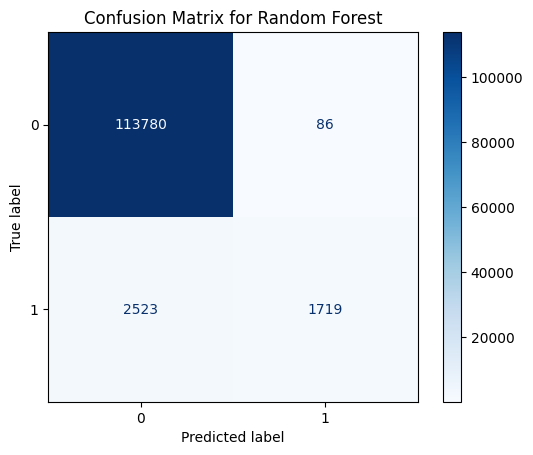

In [ ]:
# Plot Confusion Matrix for Random Forest
plot_confusion_matrix(y_val, y_val_pred_rf, 'Random Forest')

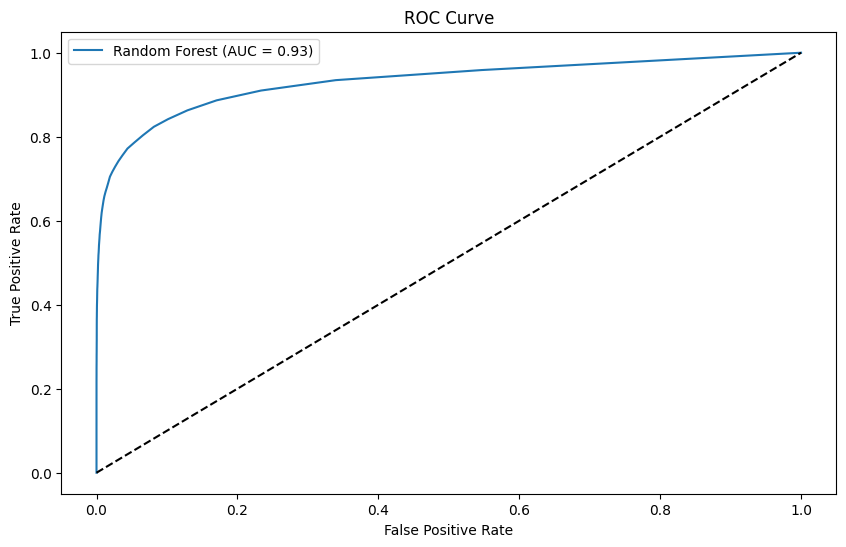

In [ ]:
# Plot ROC Curve for Random Forest
plot_roc_curve(y_val, y_val_pred_proba_rf, 'Random Forest')


In [ ]:
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 2.0 MB/s eta 0:00:00


In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train XGBoost
gb = xgb.XGBClassifier(n_estimators=100, max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss')
gb.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred_proba_gb = gb.predict_proba(X_val)[:, 1]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:30:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Calculate ROC AUC
roc_auc_gb = roc_auc_score(y_val, y_val_pred_proba_gb)
print("XGBoost ROC AUC:", roc_auc_gb)

XGBoost ROC AUC: 0.9077410697552437


In [ ]:
# Classification report
y_val_pred_gb = (y_val_pred_proba_gb > 0.3).astype(int)
print("Classification Report:")
print(classification_report(y_val, y_val_pred_gb))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113866
           1       0.77      0.46      0.57      4242

    accuracy                           0.98    118108
   macro avg       0.88      0.73      0.78    118108
weighted avg       0.97      0.98      0.97    118108



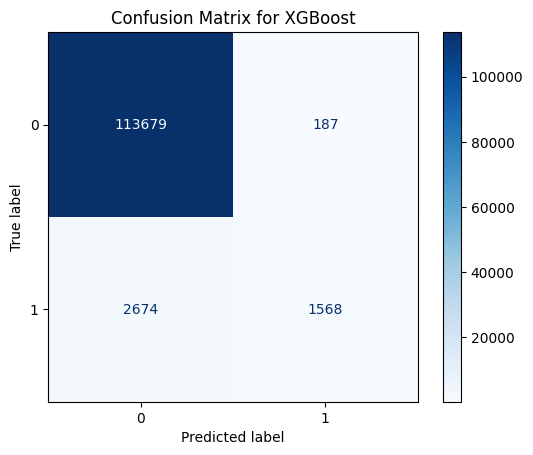

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for XGBoost')
plt.show()

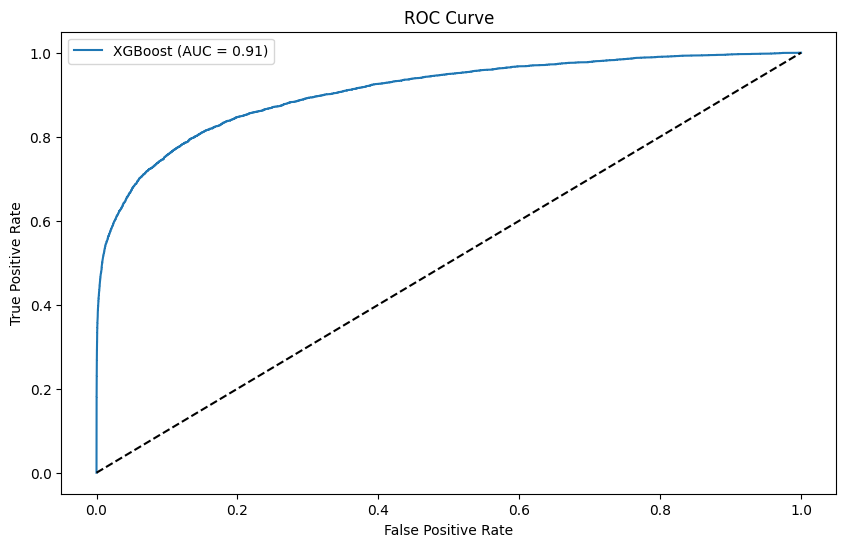

In [ ]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba_gb)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# Make predictions on the test set using the best model
y_test_pred_proba = rf.predict_proba(X_test_aligned)[:, 1]

# Prepare the submission file
submission = pd.DataFrame({
    'TransactionID': test['TransactionID'],
    'isFraud': y_test_pred_proba
})



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [ ]:
# Define the architecture of the neural network
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
# Build the model
input_dim = X_train.shape[1]
model = build_model(input_dim)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])


In [ ]:
# Define early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
print(X_train.dtypes.value_counts())
print(y_train.dtype)

bool       2401
float64     402
Name: count, dtype: int64
int8


In [ ]:
print("NaN in X_train:", X_train.isna().any().any())
print("Inf in X_train:", np.isinf(X_train).any().any())
print("NaN in y_train:", y_train.isna().any())
print("Inf in y_train:", np.isinf(y_train).any())

NaN in X_train: False
Inf in X_train: False
NaN in y_train: False
Inf in y_train: False


In [ ]:
X_train_np = X_train.to_numpy().astype(np.float32)
y_train_np = y_train.to_numpy().astype(np.float32)
X_val_np = X_val.to_numpy().astype(np.float32)
y_val_np = y_val.to_numpy().astype(np.float32)

# Now try fitting the model with these numpy arrays
history = model.fit(X_train_np, y_train_np,
                    validation_data=(X_val_np, y_val_np),
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/100
1846/1846 [==============================] - 12s 6ms/step - loss: 0.1271 - auc: 0.8084 - val_loss: 0.1015 - val_auc: 0.8762
Epoch 2/100
1846/1846 [==============================] - 8s 5ms/step - loss: 0.1077 - auc: 0.8500 - val_loss: 0.0981 - val_auc: 0.8853
Epoch 3/100
1846/1846 [==============================] - 8s 5ms/step - loss: 0.1024 - auc: 0.8643 - val_loss: 0.0966 - val_auc: 0.8891
Epoch 4/100
1846/1846 [==============================] - 9s 5ms/step - loss: 0.0994 - auc: 0.8701 - val_loss: 0.0943 - val_auc: 0.8943
Epoch 5/100
1846/1846 [==============================] - 9s 5ms/step - loss: 0.0968 - auc: 0.8787 - val_loss: 0.0921 - val_auc: 0.8960
Epoch 6/100
1846/1846 [==============================] - 9s 5ms/step - loss: 0.0952 - auc: 0.8815 - val_loss: 0.0919 - val_auc: 0.8993
Epoch 7/100
1846/1846 [==============================] - 9s 5ms/step - loss: 0.0932 - auc: 0.8851 - val_loss: 0.0909 - val_auc: 0.9017
Epoch 8/100
1846/1846 [==============================]

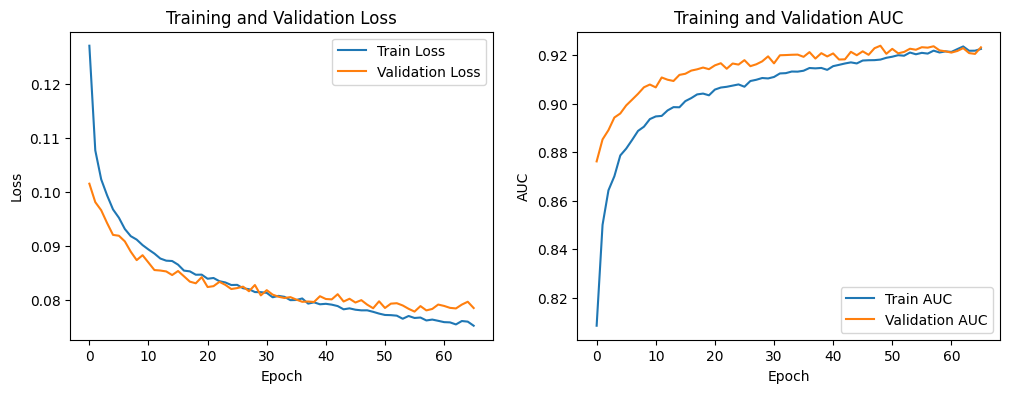

In [ ]:
# Plot training & validation loss and AUC values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()

plt.show()


In [ ]:
# Make predictions on the validation set
y_val_pred_proba_dl = model.predict(X_val_np).ravel()


3691/3691 [==============================] - 5s 1ms/step


In [ ]:
# Calculate ROC AUC
roc_auc_dl = roc_auc_score(y_val, y_val_pred_proba_dl)
print("Deep Learning Model ROC AUC:", roc_auc_dl)

Deep Learning Model ROC AUC: 0.9246724613055639


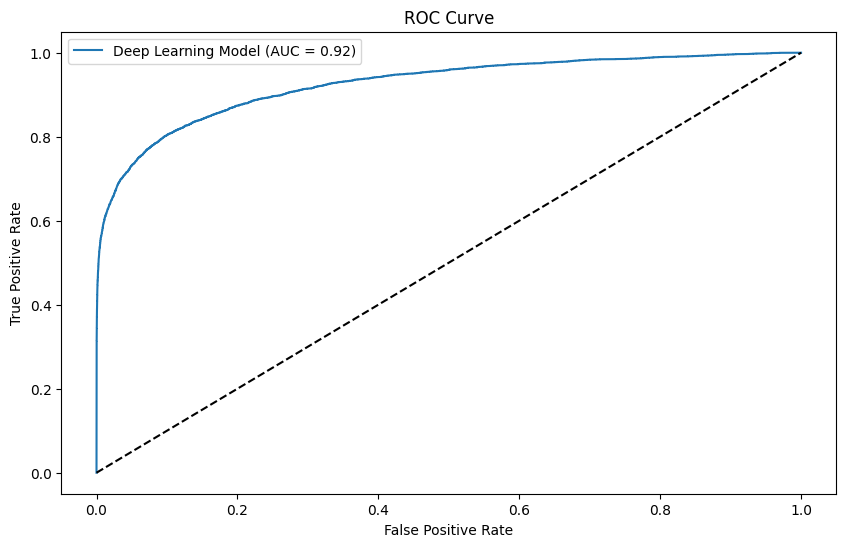

In [ ]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba_dl)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Deep Learning Model (AUC = {roc_auc_dl:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# Classification report
y_val_pred_dl = (y_val_pred_proba_dl > 0.3).astype(int)
print("Classification Report:")
print(classification_report(y_val, y_val_pred_dl))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113866
           1       0.84      0.52      0.64      4242

    accuracy                           0.98    118108
   macro avg       0.91      0.76      0.82    118108
weighted avg       0.98      0.98      0.98    118108



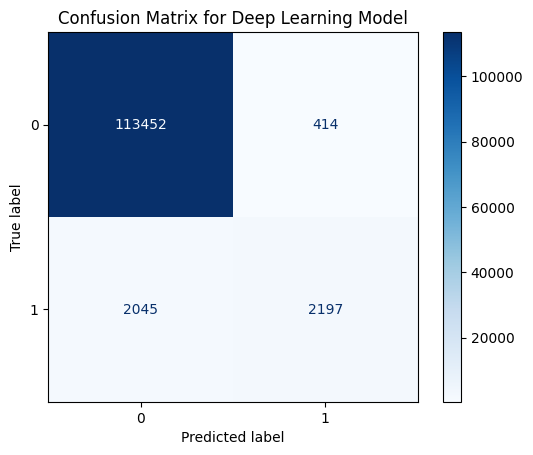

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_dl)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Deep Learning Model')
plt.show()

In [ ]:
X_test_np = X_test_aligned.to_numpy().astype(np.float32)

In [ ]:
print("X_test_np shape:", X_test_np.shape)
print("X_test_np dtype:", X_test_np.dtype)

X_test_np shape: (506691, 2803)
X_test_np dtype: float32


In [ ]:
print("X_train_np shape:", X_train_np.shape)
print("X_test_np shape:", X_test_np.shape)

X_train_np shape: (472432, 2803)
X_test_np shape: (506691, 2803)


In [ ]:
# Make predictions on the test set
y_test_pred_proba_dl = model.predict(X_test_np).ravel()



15835/15835 [==============================] - 21s 1ms/step
